In [18]:
import os
import random
from tqdm import tqdm
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset 
from aijack.attack import GradientInversion_Attack
from matplotlib import pyplot as plt  
torch.backends.cudnn.benchmark=True

torch.cuda.empty_cache()

In [19]:
num_clients = 10
num_selected = 10
num_rounds = 5
epochs = 5
batch_size = 3
client_victim = 1
data = "CIFAR10"
chosen_model = ''
if data == "CIFAR10":
    chosen_model = 'test'
    channels = 3
    norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    hideen=768
    img_shape = (channels, 32, 32)
else:
    chosen_model = 'test'
    channels = 1
    norm = transforms.Normalize((0.5), (0.5))
    hideen=588
    img_shape = (channels, 28, 28)
criterion = nn.CrossEntropyLoss()

In [25]:
#############################################################
##### Creating desired data distribution among clients  #####
#############################################################

# Image augmentation 
transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # norm,
])

if data == "CIFAR10":
    # Loading CIFAR10 using torchvision.datasets
    traindata = datasets.CIFAR10('./data', train=True, download=True,
                        transform= transform_train)
else:
    # Loading CIFAR10 using torchvision.datasets
    traindata = datasets.MNIST('./data', train=True, download=True,
                        transform= transform_train)

# Dividing the training data into num_clients, with each client having equal number of images
# traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in range(num_clients)])

traindata_split = torch.utils.data.random_split(traindata, [100 for _ in range(500)])
traindata_split = traindata_split[:10]
torch.save(traindata_split, '../../data/cifar10.pth')

# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in torch.load('../../data/MNIST.pth')]

# Normalizing the test images
transform_test = transforms.Compose([
    transforms.ToTensor(),
    norm,
])

if data == "CIFAR10":
    # Loading the test iamges and thus converting them into a test_loader
    test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('./data', train=False, transform=transform_test
            ), batch_size=batch_size, shuffle=True)
else:
    # Loading the test iamges and thus converting them into a test_loader
    test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('./data', train=False, transform=transform_test
            ), batch_size=batch_size, shuffle=True)

Files already downloaded and verified


torch.Size([1, 28, 28])


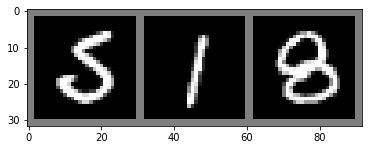

dog   car   ship 


In [24]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader[0])
images, labels = dataiter.next()

print(images[0].shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
#################################
##### Neural Network model #####
#################################

class VGG(nn.Module):
    def __init__(self, channels=channels, hideen=hideen, num_classes=10):
        super(VGG, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=(3,3), stride=(2,2), padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(2,2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(12544, num_classes)
            # nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:

def client_update(client_model, optimizer, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            # loss = F.nll_loss(output, target)
            loss = criterion(output, target)
            loss.backward(retain_graph=True)
            
            received_gradients = torch.autograd.grad(loss, client_model.parameters())
            received_gradients = [cg.detach() for cg in received_gradients]            
                
            optimizer.step()
    return loss, received_gradients

In [ ]:
def server_aggregate(global_model, client_models):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [ ]:
def test(global_model, test_loader):
    """This function test the global model on test data and returns test loss and test accuracy """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = global_model(data)
            # test_loss += F.nll_loss(output, target).item() # sum up batch loss
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

In [ ]:
############################################
#### Initializing models and optimizer  ####
############################################

#### global model ##########
global_model =  VGG().cuda()

############## client models ##############
client_models = [ VGG().cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

###### List containing info about learning #########
losses_train = []
losses_test = []
acc_train = []
acc_test = []
# Runnining FL

victim_count = 0 
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    # client update
    loss = 0
    
    for i in tqdm(range(num_selected)):
        client_loss, received_gradients = client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=1)
        loss += client_loss.item()
        
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models)
    
    test_loss, acc = test(global_model, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))


In [ ]:
print(global_model.fc[0].weight.shape)
global_model.fc[0].weight

In [ ]:
{k: (v.dtype, v.shape) for k, v in global_model.state_dict().items()}

In [ ]:
torch_weights = global_model.body.state_dict()
# Reshape weights for Keras model
keras_weights = [w.cpu().numpy() for w in torch_weights.values()]

for i in [0, 2, 9, 16]:
    print(keras_weights[i].shape)
    # conv2d layer: Torch (out,in,h,w) Keras (h,w,in,out)
    keras_weights[i] = np.moveaxis(keras_weights[i], [0,1], [-1,-2])

keras_weights.append(global_model.fc[0].weight.cpu().detach().numpy().T)
print(keras_weights[len(keras_weights)-1].shape)


In [ ]:
# torch.save(global_model, "../../pretrained/test_torch.pt")

In [ ]:
torch_model = torch.load("../../pretrained/test_torch.pt")
torch_weights = torch_model.body.state_dict()
# Reshape weights for Keras model
keras_weights = [w.cpu().numpy() for w in torch_weights.values()]

for i in [0, 2, 9, 16]:
    print(keras_weights[i].shape)
    # conv2d layer: Torch (out,in,h,w) Keras (h,w,in,out)
    keras_weights[i] = np.moveaxis(keras_weights[i], [0,1], [-1,-2])
keras_weights.append(torch_model.fc[0].weight.cpu().detach().numpy().T)
print(keras_weights[len(keras_weights)-1].shape)

In [ ]:
new_keras = [v for v in keras_weights if v.shape != ()]
len(new_keras)